<div style="background-color:#f0f8ff; padding:10px; border:1px solid #ccc; border-radius:5px;">

# Project Overview

</div>

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import joblib

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Machine Learning
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from lightgbm import Booster
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Optimization
import optuna

# Pandas display option
pd.set_option('display.max_rows', 200)

<div style="background-color:#f0f8ff; padding:10px; border:1px solid #ccc; border-radius:5px;">

# Import Data

In this notebook, I use the data which is provided by Kaggle.  
https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/data


First of all, I dowloaded the data ( new-york-city-taxi-fare-prediction.zip ) from kaggle.  
Next, I've created the parquet file which is more efficient format than csv.


Since the original `train.csv` contains over 55 million rows,  
in this notebook, I used a 3% sample of the data.

```

$ wc -l train.csv
 55423856 train.csv
 
```

<br>
To train and evaluate the model reliably, I split 3% of the full dataset into three equal parts (1% each), with clearly separated purposes:


| Purpose                     | Size | Description                                                                                          |
| --------------------------- | ---- | ---------------------------------------------------------------------------------------------------- |
| **1. For 5-Fold CV**        | 1%   | Used for hyperparameter tuning using Optuna with 5-fold cross-validation.                            |
| **2. For Final Training**   | 1%   | Used to train the final model with the best parameters found in tuning.                              |
| **3. For Final Evaluation** | 1%   | Completely untouched during training. Used to evaluate the final model’s generalization performance. |


</div>




In [2]:
######################################################################
# This cell's role is creating parquet file.
# Since I don't need to create it again, this cell is commented out.
######################################################################

# tmp_df_csv = pd.read_csv("../data/train.csv")
# tmp_df_sample = tmp_df_csv.sample(frac=0.03, random_state=5)
# tmp_df_sample.to_parquet("../data/train_sample_3pct.parquet")

In [3]:
df_train = pd.read_parquet("../data/train_sample_3pct.parquet")

<div style="background-color:#f0f8ff; padding:10px; border:1px solid #ccc; border-radius:5px;">

# Data Overview


The df_train dataframe has `554239` rows and `8` columns.  
It provides us with information about New York City taxi fares.  
It contains the following columns.  

```
fare_amount
pickup_datetime
pickup_longitude
pickup_latitude
dropoff_longitude
dropoff_latitude
passenger_count
```

</div>


In [4]:
print(df_train.shape[0])
print(df_train.shape[1])

1662716
8


In [5]:
print(df_train.columns.tolist())
df_train.head().T

['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']


,2023872,31491827,17432554,31288354,36946446
key,2013-12-16 16:11:16.0000003,2009-12-27 23:40:00.0000001,2010-12-21 16:38:50.0000001,2009-10-27 23:39:00.00000074,2011-01-24 08:02:00.00000064
fare_amount,7.5,6.5,9.7,5.7,6.1
pickup_datetime,2013-12-16 16:11:16 UTC,2009-12-27 23:40:00 UTC,2010-12-21 16:38:50 UTC,2009-10-27 23:39:00 UTC,2011-01-24 08:02:00 UTC
pickup_longitude,-73.960983,-73.988613,-73.951529,-73.994923,-73.978977
pickup_latitude,40.770016,40.748513,40.766517,40.741438,40.762112
dropoff_longitude,-73.97195,-73.988073,-73.981065,-73.996513,-73.97677
dropoff_latitude,40.782227,40.763215,40.784278,40.727122,40.753233
passenger_count,1,2,1,1,1


<div style="background-color:#f0f8ff; padding:10px; border:1px solid #ccc; border-radius:5px;">

# Preprocessing

This section covers preprocessing steps.  
I check and remove records with missing values,  
as well as unrealistic entries such as trips with no passengers or more than 7 passengers.  

In addition, some columns are converted to datetime format so that feature engineering is easier in the next step.

</div>


In [6]:
print(df_train.isnull().sum())

key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    14
dropoff_latitude     14
passenger_count       0
dtype: int64


In [7]:
# Remove missing values
df_train = df_train.dropna()
df_train = df_train[df_train["fare_amount"] > 0].copy()

print(df_train.isnull().sum())
print(len(df_train))

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64
1662559


In [8]:
# Check if the passenger count contains unrealistic numbers
print(df_train["passenger_count"].value_counts().sort_index())

passenger_count
0         5796
1      1150845
2       245280
3        72945
4        35140
5       117488
6        35062
7            1
208          2
Name: count, dtype: int64


In [9]:
# Remove unrealistic passenger counts (0 or less, and more than 6)
df_train = df_train[(df_train["passenger_count"] >= 1) & (df_train["passenger_count"] <= 6)]

In [10]:
# Check if the passenger count contains unrealistic numbers
print(df_train["passenger_count"].value_counts().sort_index())

passenger_count
1    1150845
2     245280
3      72945
4      35140
5     117488
6      35062
Name: count, dtype: int64


In [11]:
# Convert to datetime type
df_train["pickup_datetime"] = pd.to_datetime(df_train["pickup_datetime"])

df_train["year"] = df_train["pickup_datetime"].dt.year
df_train["month"] = df_train["pickup_datetime"].dt.month
df_train["weekday"] = df_train["pickup_datetime"].dt.weekday  # Monday=0, Sunday=6
df_train["hour"] = df_train["pickup_datetime"].dt.hour

<div style="background-color:#f0f8ff; padding:10px; border:1px solid #ccc; border-radius:5px;">

# feature enginnering

</div>


In [12]:
def haversine_distance(from_lat, from_lon, to_lat, to_lon):
    # convert degrees to radians
    from_lat, from_lon, to_lat, to_lon = map(np.radians, [from_lat, from_lon, to_lat, to_lon])
    
    # difference
    dlat = to_lat - from_lat
    dlon = to_lon - from_lon

    # haversine formula
    a = np.sin(dlat / 2)**2 + np.cos(from_lat) * np.cos(to_lat) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    return 6371 * c  # Earth radius in km

# add distance_km column
df_train["distance_km"] = haversine_distance(
    df_train["pickup_latitude"],
    df_train["pickup_longitude"],
    df_train["dropoff_latitude"],
    df_train["dropoff_longitude"]
)


In [13]:
def haversine_np(lat1, lon1, lat2, lon2):
    # convert degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return 6371 * c  # in km

# latitude and longitude of landmarks
locations = {
    "JFK": (40.6413, -73.7781),
    "LGA": (40.7769, -73.8740),
    "EWR": (40.6895, -74.1745),
    "Penn_Station": (40.7506, -73.9935),
    "Grand_Central": (40.7527, -73.9772),
    "Times_Square": (40.7580, -73.9855),
}

# compute distances to landmarks
for name, (lat, lon) in locations.items():
    df_train[f"pickup_distance_to_{name}"] = haversine_np(
        df_train["pickup_latitude"], df_train["pickup_longitude"],
        lat, lon
    )
    df_train[f"dropoff_distance_to_{name}"] = haversine_np(
        df_train["dropoff_latitude"], df_train["dropoff_longitude"],
        lat, lon
    )

In [14]:
# only longitude changes → east-west
east_west = haversine_np(
    df_train["pickup_latitude"], df_train["pickup_longitude"],
    df_train["pickup_latitude"], df_train["dropoff_longitude"]
)

# only latitude changes → north-south
north_south = haversine_np(
    df_train["pickup_latitude"], df_train["dropoff_longitude"],
    df_train["dropoff_latitude"], df_train["dropoff_longitude"]
)

# Manhattan distance = east-west + north-south
df_train["manhattan_km"] = east_west + north_south

In [15]:
from sklearn.cluster import KMeans

# pickup clusters
pickup_coords = df_train[["pickup_latitude", "pickup_longitude"]]
kmeans_pickup = KMeans(n_clusters=25, random_state=5)
df_train["pickup_cluster"] = kmeans_pickup.fit_predict(pickup_coords)

# dropoff clusters
dropoff_coords = df_train[["dropoff_latitude", "dropoff_longitude"]]
kmeans_dropoff = KMeans(n_clusters=25, random_state=5)
df_train["dropoff_cluster"] = kmeans_dropoff.fit_predict(dropoff_coords)

# save models
joblib.dump(kmeans_pickup, "pickup_kmeans.pkl")
joblib.dump(kmeans_dropoff, "dropoff_kmeans.pkl")

['dropoff_kmeans.pkl']

In [16]:
df_train["delta_latitude"] = df_train["dropoff_latitude"] - df_train["pickup_latitude"]
df_train["delta_longitude"] = df_train["dropoff_longitude"] - df_train["pickup_longitude"]
df_train["path_efficiency"] = df_train["distance_km"] / df_train["manhattan_km"].replace(0, np.nan)

df_train["pickup_vs_dropoff_to_JFK"] = (
    df_train["pickup_distance_to_JFK"] - df_train["dropoff_distance_to_JFK"]
)

# クラスタ別の平均距離
pickup_cluster_avg_fare = df_train.groupby("pickup_cluster")["fare_amount"].mean().rename("pickup_cluster_avg_fare")
df_train = df_train.join(pickup_cluster_avg_fare, on="pickup_cluster")


In [17]:
# JFK latitude and longitude
jfk_lat, jfk_lon = 40.6413, -73.7781

df_train["is_jfk_pickup"] = (df_train["pickup_distance_to_JFK"] < 1.0).astype(int)
df_train["is_jfk_dropoff"] = (df_train["dropoff_distance_to_JFK"] < 1.0).astype(int)

In [18]:
dt = df_train["pickup_datetime"].dt

df_train["holiday_flag"] = (
    ((dt.month == 1) & (dt.day == 1)) |     # New Year's Day
    ((dt.month == 7) & (dt.day == 4)) |     # Independence Day
    ((dt.month == 12) & (dt.day == 25)) |   # Christmas Day
    ((dt.month == 12) & (dt.day == 31))     # New Year's Eve
).astype(int)

print(df_train["holiday_flag"].value_counts())

holiday_flag
0    1644154
1      12606
Name: count, dtype: int64


In [19]:
print(df_train.columns.tolist())
df_train.head().T

['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year', 'month', 'weekday', 'hour', 'distance_km', 'pickup_distance_to_JFK', 'dropoff_distance_to_JFK', 'pickup_distance_to_LGA', 'dropoff_distance_to_LGA', 'pickup_distance_to_EWR', 'dropoff_distance_to_EWR', 'pickup_distance_to_Penn_Station', 'dropoff_distance_to_Penn_Station', 'pickup_distance_to_Grand_Central', 'dropoff_distance_to_Grand_Central', 'pickup_distance_to_Times_Square', 'dropoff_distance_to_Times_Square', 'manhattan_km', 'pickup_cluster', 'dropoff_cluster', 'delta_latitude', 'delta_longitude', 'path_efficiency', 'pickup_vs_dropoff_to_JFK', 'pickup_cluster_avg_fare', 'is_jfk_pickup', 'is_jfk_dropoff', 'holiday_flag']


,2023872,31491827,17432554,31288354,36946446
key,2013-12-16 16:11:16.0000003,2009-12-27 23:40:00.0000001,2010-12-21 16:38:50.0000001,2009-10-27 23:39:00.00000074,2011-01-24 08:02:00.00000064
fare_amount,7.5,6.5,9.7,5.7,6.1
pickup_datetime,2013-12-16 16:11:16+00:00,2009-12-27 23:40:00+00:00,2010-12-21 16:38:50+00:00,2009-10-27 23:39:00+00:00,2011-01-24 08:02:00+00:00
pickup_longitude,-73.960983,-73.988613,-73.951529,-73.994923,-73.978977
pickup_latitude,40.770016,40.748513,40.766517,40.741438,40.762112
dropoff_longitude,-73.97195,-73.988073,-73.981065,-73.996513,-73.97677
dropoff_latitude,40.782227,40.763215,40.784278,40.727122,40.753233
passenger_count,1,2,1,1,1
year,2013,2009,2010,2009,2011
month,12,12,12,10,1


<div style="background-color:#f0f8ff; padding:10px; border:1px solid #ccc; border-radius:5px;">

# Modeling

</div>


In [20]:
features = [
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude',
    'passenger_count',
    'year',
    'month',
    'weekday',
    'hour',
    'distance_km',
    'manhattan_km',
    'pickup_distance_to_JFK',
    'dropoff_distance_to_JFK',
    'pickup_distance_to_LGA',
    'dropoff_distance_to_LGA',
    'pickup_distance_to_EWR',
    'dropoff_distance_to_EWR',
    'pickup_distance_to_Penn_Station',
    'dropoff_distance_to_Penn_Station',
    'pickup_distance_to_Grand_Central',
    'dropoff_distance_to_Grand_Central',
    'pickup_distance_to_Times_Square',
    'dropoff_distance_to_Times_Square',
    'holiday_flag',
    'pickup_cluster',
    'dropoff_cluster',
    "delta_latitude",
    "delta_longitude",
    "path_efficiency",
    "pickup_vs_dropoff_to_JFK",
    "pickup_cluster_avg_fare",
    'is_jfk_pickup',
    'is_jfk_dropoff',
]

# 3%のうち、1%分だけ使う
df_fold = df_train.sample(frac=1/3, random_state=5)

X = df_fold[features]
y = np.log1p(df_fold["fare_amount"])

kf = KFold(n_splits=5, shuffle=True, random_state=5)

mae_scores = []
rmse_scores = []

baseline_params = {
    "n_estimators": 1000,
    "learning_rate": 0.1,
    "random_state": 5,
}


for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    model = LGBMRegressor(**baseline_params)
   
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val.values)],
        eval_metric="rmse",
        callbacks=[
            early_stopping(50),
            log_evaluation(100)
        ]
    )
    
    y_pred_log = model.predict(X_val)
    y_pred = np.expm1(y_pred_log)
    y_val_orig = np.expm1(y_val)

    rmse = np.sqrt(mean_squared_error(y_val_orig, y_pred))
    mae = mean_absolute_error(y_val_orig, y_pred)

    rmse_scores.append(rmse)
    mae_scores.append(mae)

print(f"Mean RMSE: {np.mean(rmse_scores):.4f}")
print(f"Mean MAE : {np.mean(mae_scores):.4f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006915 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5695
[LightGBM] [Info] Number of data points in the train set: 441802, number of used features: 33
[LightGBM] [Info] Start training from score 2.333186
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 0.228034	valid_0's l2: 0.0519995
[200]	valid_0's rmse: 0.225042	valid_0's l2: 0.0506441
[300]	valid_0's rmse: 0.224097	valid_0's l2: 0.0502196
[400]	valid_0's rmse: 0.223413	valid_0's l2: 0.0499132
[500]	valid_0's rmse: 0.222922	valid_0's l2: 0.0496941
[600]	valid_0's rmse: 0.222568	valid_0's l2: 0.0495364
[700]	valid_0's rmse: 0.222304	valid_0's l2: 0.0494191
[800]	valid_0's rmse: 0.222111	valid_0's l2: 0.0493333
[900]	valid_0's rmse: 0.222125	valid_0's l2: 0.0493393
[1000]	valid_0's rmse: 0.221997	valid

In [21]:
# calculate absolute errors
errors = np.abs(y_val - y_pred)

# define error bins and labels
bins = [0, 1, 2, 3, 5, 10, 20, np.inf]
labels = ['0–1$', '1–2$', '2–3$', '3–5$', '5–10$', '10–20$', '20+$']

# categorize errors into bins
error_bins = pd.cut(errors, bins=bins, labels=labels, right=False)

# count errors in each bin
error_summary = error_bins.value_counts().sort_index().to_frame(name='count')

# add percentage and cumulative percentage
error_summary['percent(%)'] = (error_summary['count'] / len(errors) * 100).round(2)
error_summary['cumulative(%)'] = error_summary['percent(%)'].cumsum().round(2)

# show table
display(error_summary)

,count,percent(%),cumulative(%)
fare_amount,,,
0–1$,36,0.03,0.03
1–2$,300,0.27,0.30
2–3$,7953,7.20,7.50
3–5$,31362,28.39,35.89
5–10$,45404,41.11,77.00
10–20$,17592,15.93,92.93
20+$,7803,7.06,99.99


In [22]:
def plot_fare_distribution(y_actual, y_predicted, title_suffix=""):

    bins = np.arange(0, 100, 1)
    actual_counts, _ = np.histogram(y_actual, bins=bins)
    pred_counts, _ = np.histogram(y_predicted, bins=bins)
    bin_centers = bins[:-1] + 0.5

    plt.figure(figsize=(10, 6))
    plt.bar(
        bin_centers, actual_counts, width=1.0,
        alpha=0.5, label='Actual', color='blue', edgecolor='black'
    )
    plt.plot(
        bin_centers, pred_counts,
        label='Predicted', color='orange', linewidth=2
    )

    plt.xlabel('Fare Amount ($)')
    plt.ylabel('Count')
    plt.title(f'Fare Amount Distribution: Actual vs Predicted {title_suffix}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


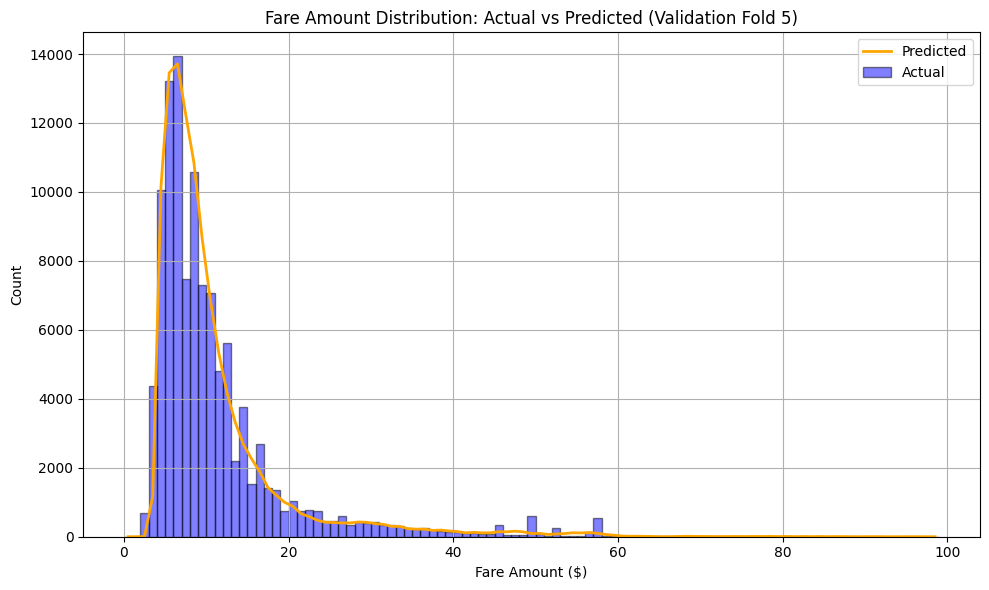

In [23]:
plot_fare_distribution(y_val_orig, y_pred, title_suffix="(Validation Fold 5)")

<div style="background-color:#f0f8ff; padding:10px; border:1px solid #ccc; border-radius:5px;">

# SHAP

</div>

In [24]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val)

shap_df = pd.DataFrame(shap_values, columns=X_val.columns, index=X_val.index)

shap_summary_df = pd.DataFrame({
    'Mean(|SHAP|)': shap_df.abs().mean(),
}).sort_values(by='Mean(|SHAP|)', ascending=False)

display(shap_summary_df)

,Mean(|SHAP|)
distance_km,0.334657
year,0.072706
hour,0.039828
pickup_vs_dropoff_to_JFK,0.035995
month,0.018634
weekday,0.017961
delta_longitude,0.016424
pickup_distance_to_Grand_Central,0.014837
path_efficiency,0.013970
dropoff_distance_to_JFK,0.012605


<div style="background-color:#f0f8ff; padding:10px; border:1px solid #ccc; border-radius:5px;">

# Optuna

</div>

In [ ]:
optuna_baseline = {
    "learning_rate": baseline_params["learning_rate"],
    "num_leaves": 31,
    "max_depth": -1,
    "subsample": 1.0,
    "colsample_bytree": 1.0
}

def objective(trial):
    params = {
        "n_estimators": baseline_params["n_estimators"],
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "num_leaves": trial.suggest_int("num_leaves", 31, 127),
        "max_depth": trial.suggest_int("max_depth", 5, 15),
        "subsample": trial.suggest_float("subsample", 0.7, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 1.0),
        "random_state": baseline_params["random_state"],
        "n_jobs": -1,
        "verbosity": -1,

    }

    kf = KFold(n_splits=5, shuffle=True, random_state=5)
    rmse_scores = []

    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = LGBMRegressor(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric="rmse",
            callbacks=[
                early_stopping(50),
                log_evaluation(0),
            ],
        )

        y_pred = model.predict(X_val)
        y_val_orig = np.expm1(y_val)
        y_pred_orig = np.expm1(y_pred)
        rmse = np.sqrt(mean_squared_error(y_val_orig, y_pred_orig))
        rmse_scores.append(rmse)

    return np.mean(rmse_scores)

study = optuna.create_study(direction="minimize")
study.enqueue_trial(optuna_baseline)
study.optimize(objective, n_trials=2)

print("Best RMSE:", study.best_value)
print("Best params:", study.best_params)

[I 2025-07-28 00:20:16,475] A new study created in memory with name: no-name-1333fd83-871e-44ab-bae3-a4e519f45e91
/opt/anaconda3/envs/ml-supervised-regression-nyc-taxi-fare/lib/python3.12/site-packages/optuna/trial/_trial.py:656: UserWarning: Fixed parameter 'max_depth' with value -1 is out of range for distribution IntDistribution(high=15, log=False, low=5, step=1).
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.221997	valid_0's l2: 0.0492826
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[892]	valid_0's rmse: 0.223479	valid_0's l2: 0.0499429
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[897]	valid_0's rmse: 0.22456	valid_0's l2: 0.0504273
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[718]	valid_0's rmse: 0.224562	valid_0's l2: 0.0504283
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[703]	valid_0's rmse: 0.220744	valid_0's l2: 0.0487278


[I 2025-07-28 00:21:05,772] Trial 0 finished with value: 4.4051267120892845 and parameters: {'learning_rate': 0.1, 'num_leaves': 31, 'max_depth': -1, 'subsample': 1.0, 'colsample_bytree': 1.0}. Best is trial 0 with value: 4.4051267120892845.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[754]	valid_0's rmse: 0.220923	valid_0's l2: 0.048807
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[767]	valid_0's rmse: 0.222131	valid_0's l2: 0.0493424
Training until validation scores don't improve for 50 rounds


<div style="background-color:#f0f8ff; padding:10px; border:1px solid #ccc; border-radius:5px;">

# Final Model

I created final mode in this cell.  
It was created with best hyperparameter that was set by Optuna.

</div>

In [ ]:
from lightgbm import LGBMRegressor, Booster
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Use best parameters found by Optuna
best_params = study.best_params.copy()
best_params.update({
    "n_estimators": 1000,
    "random_state": 5,
    "n_jobs": -1
})

# Train the final model (X, y are from df_fold, which is 1% of total 3%)
final_model = LGBMRegressor(**best_params)
final_model.fit(X, y)
final_model.booster_.save_model("final_model_1percent.txt")

# Prepare test data (another 1% not used in training or cross-validation)
df_remaining = df_train.drop(df_fold.index)
df_final_test = df_remaining.sample(frac=0.5, random_state=5)
df_final_test = df_final_test[df_final_test["fare_amount"] > 0].copy()

X_test = df_final_test[features]
y_test = np.log1p(df_final_test["fare_amount"])

# Load the trained model using Booster
model = Booster(model_file="final_model_1percent.txt")


<div style="background-color:#f0f8ff; padding:10px; border:1px solid #ccc; border-radius:5px;">

# Evaluate the Final Model

Finally, I evaluated the final model.  

I confirmed that it improved the scores such as RMSE and MAE.  
I also drew a bar graph and confirmed that the predicted line fits the actual values well.

</div>


In [ ]:
# Predict and inverse transform the target
final_y_pred_log = model.predict(X_test)
final_y_test_orig = np.expm1(y_test)
final_y_pred_orig = np.expm1(final_y_pred_log)

# Calculate evaluation metrics
final_rmse = np.sqrt(mean_squared_error(final_y_test_orig, final_y_pred_orig))
final_mae = mean_absolute_error(final_y_test_orig, final_y_pred_orig)

# Output metrics for both CV and final evaluation
print("Evaluation on the last fold of 5-fold cross-validation")
print(f"Mean RMSE: {np.mean(rmse_scores):.4f}")
print(f"Mean MAE : {np.mean(mae_scores):.4f}")

print("\nEvaluation on the final model")
print(f"Final model RMSE: {final_rmse:.4f}")
print(f"Final model MAE : {final_mae:.4f}")

In [ ]:
plot_fare_distribution(final_y_test_orig, final_y_pred_orig, title_suffix="(Final Test)")